In [1]:
!pip install -e ../..

Obtaining file:///home/egor/Documents/FCApy
  Attempting uninstall: fcapy
    Found existing installation: fcapy 0.1.2
    Uninstalling fcapy-0.1.2:
      Successfully uninstalled fcapy-0.1.2
  Running setup.py develop for fcapy
You should consider upgrading via the '/home/egor/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

In [3]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import ConceptLatticeVisualizer, POSetVisualizer

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
import decision_tree_structure as dts

# Motivation

# Decision Trees to construct a lattice of concepts

## Running Example

Load the data

In [6]:
K = FormalContext.read_csv('../../data/mango_bin.csv')
K_df = K.to_pandas()
K_df = K_df[['color_is_yellow', 'color_is_green', 'color_is_blue', 'color_is_white', 'form_is_round', 'form_is_oval', 'form_is_cubic', 'firm', 'smooth', 'fruit']]
K_df

,color_is_yellow,color_is_green,color_is_blue,color_is_white,form_is_round,form_is_oval,form_is_cubic,firm,smooth,fruit
apple,True,False,False,False,True,False,False,False,True,True
grapefruit,True,False,False,False,True,False,False,False,False,True
kiwi,False,True,False,False,False,True,False,False,False,True
plum,False,False,True,False,False,True,False,False,True,True
toy cube,False,True,False,False,False,False,True,True,True,False
egg,False,False,False,True,False,True,False,True,True,False
tennis ball,False,False,False,True,True,False,False,False,False,False
mango,False,True,False,False,False,True,False,False,True,True


In [7]:
K_df.columns = pd.MultiIndex.from_tuples([f.split('_is_') if '_is_' in f else (f, '') for f in K_df.columns])
K_df = K_df.replace({True: 'X', False:''})
K_df['fruit'] = K_df['fruit'].replace({'X':1, '':0})

In [8]:
print(K_df.to_latex())

\begin{tabular}{llllllllllr}
\toprule
{} & \multicolumn{4}{l}{color} & \multicolumn{3}{l}{form} & firm & smooth & fruit \\
{} & yellow & green & blue & white & round & oval & \multicolumn{4}{l}{cubic} \\
\midrule
apple       &      X &       &      &       &     X &      &       &      &      X &     1 \\
grapefruit  &      X &       &      &       &     X &      &       &      &        &     1 \\
kiwi        &        &     X &      &       &       &    X &       &      &        &     1 \\
plum        &        &       &    X &       &       &    X &       &      &      X &     1 \\
toy cube    &        &     X &      &       &       &      &     X &    X &      X &     0 \\
egg         &        &       &      &     X &       &    X &       &    X &      X &     0 \\
tennis ball &        &       &      &     X &     X &      &       &      &        &     0 \\
mango       &        &     X &      &       &       &    X &       &      &      X &     1 \\
\bottomrule
\end{tabular}



In [9]:
K_df

color                   form            firm smooth fruit
            yellow green blue white round oval cubic                  
apple            X                      X                      X     1
grapefruit       X                      X                            1
kiwi                   X                     X                       1
plum                        X                X                 X     1
toy cube               X                           X    X      X     0
egg                               X          X          X      X     0
tennis ball                       X     X                            0
mango                  X                     X                 X     1

In [10]:
K_X = FormalContext.from_pandas(K.to_pandas().drop('fruit',1))

Create dichotomic version of the context

In [11]:
K_X_df = K_X.to_pandas()
K_X_dich = K_X_df.copy()
for f in list(K_X_dich.columns):
    K_X_dich[f'not_{f}'] = ~K_X_dich[f]
K_X_dich = FormalContext.from_pandas(K_X_dich)
K_X_dich

FormalContext (8 objects, 18 attributes, 72 connections)
           |firm|smooth|color_is_yellow|color_is_green|color_is_blue|...|not_color_is_blue|not_color_is_white|not_form_is_round|not_form_is_oval|not_form_is_cubic|
apple      |    |     X|              X|              |             |...|                X|                 X|                 |               X|                X|
grapefruit |    |      |              X|              |             |...|                X|                 X|                 |               X|                X|
kiwi       |    |      |               |             X|             |...|                X|                 X|                X|                |                X|
plum       |    |     X|               |              |            X|...|                 |                 X|                X|                |                X|
toy cube   |   X|     X|               |             X|             |...|                X|                 X|             

In [12]:
K_X = FormalContext.from_pandas(K_X.to_pandas().iloc[:-1])

In [13]:
x = K_X_dich.intention(['mango'])

In [14]:
K_X_dich = FormalContext.from_pandas(K_X_dich.to_pandas().iloc[:-1])

## Classification rule

In [15]:
premise = ['form_is_round']
target = K_df.loc[K.extension(premise), 'fruit'].mean()
crule = dts.ClassificationRule(premise, target)
crule

ClassificationRule(['form_is_round'],0.6666666666666666)

## Decision Tree

In [16]:
def premise_verb(premise, draw_emptyset=True):
    if len(premise) > 0:
        premise = [re.sub(r'[^_]+_is_', '', m) for m in premise]
        premise = [m.replace('_', ' ') for m in premise]
        premise = ['$\overline{\mathrm{'+m[4:].replace(' ','\ ')+'}}$' if m.startswith('not ') else m for m in premise]
    else:
        premise = ['$\emptyset$' if draw_emptyset else ''] 
    return premise

In [17]:
def label_func(el_i, DP, draw_emptyset=True):
    el = DP[el_i]
    premise = premise_verb(el.premise, draw_emptyset=draw_emptyset)
    return '\n\n\n'.join([', '.join(premise), f"{el.target:.2f}"])

In [18]:
def short_label_func(el_i, DP, draw_emptyset=True, draw_premise_len=True, max_premise_count=3, top_labels=None):
    el = DP[el_i]
    #premise = premise_verb(el.premise, draw_emptyset=False)
    
    if top_labels is None:
        premise = set(el.premise)
        for supel_i in DP.direct_super_elements(el_i):
            premise -= set(DP[supel_i].premise)
        premise = sorted(premise)
    else:
        premise = top_labels[el_i]
    premise = premise_verb(premise, draw_emptyset=False)
    
    if len(premise) > 0 and premise!=['']:
        premise_str = f"{len(premise)}: " if draw_premise_len else ""
        premise_str += ", ".join(premise[:max_premise_count])
        if len(premise_str) > 0 \
            and max_premise_count is not None and len(premise) > max_premise_count:
            premise_str += '...'
    else:
        premise_str = '$\emptyset$' if draw_emptyset else ''
    
    return '\n\n\n'.join([premise_str, f"{el.target:.2f}"])

In [19]:
def short_label_func_concept(c_i, L, max_new_intent_count=3, max_new_extent_count=3, draw_new_intent_len=True, draw_new_extent_len=True, draw_emptyset=True, top_labels=None):
    if top_labels is None:
        new_intent = L.get_concept_new_intent(c_i)
    else:
        new_intent = top_labels[c_i]

    new_intent = premise_verb(list(new_intent), draw_emptyset)
    
    if len(new_intent) > 0 and not (len(new_intent)==1 and new_intent[0] == ''):
        new_intent_str = f"{len(new_intent)}: " if draw_new_intent_len else ""
        new_intent_str += ', '.join(new_intent[:max_new_intent_count])
        if len(new_intent_str) > 0 \
                and max_new_intent_count is not None and len(new_intent) > max_new_intent_count:
            new_intent_str += '...'
    else:
        new_intent_str = ''

    new_extent = premise_verb(list(L.get_concept_new_extent(c_i)), draw_emptyset)
    if len(new_extent) > 0 and not (len(new_extent)==1 and new_extent[0] == ''):
        new_extent_str = f"{len(new_extent)}: " if draw_new_extent_len else ""
        new_extent_str += ', '.join(new_extent[:max_new_extent_count])
        if len(new_extent_str) > 0 \
                and max_new_extent_count is not None and len(new_extent) > max_new_extent_count:
            new_extent_str += '...'
    else:
        new_extent_str = ''

    label = '\n\n'.join([new_intent_str, new_extent_str])
    return label

In [20]:
def draw_decision_poset(
    dp, vsl_params, draw_node_indices=False, label_func=None, ax=None,
    dx_coefs=(0,0), dy_coefs=(0,0), xlim=None, ylim=None,
    nodes_dx=None, nodes_dy=None, nodes_pos=None,
    off_axis=True,
):    
    if ax is None:
        fig, ax = plt.subplots()
        
    nodes_dx = nodes_dx if nodes_dx is not None else {}
    nodes_dy = nodes_dy if nodes_dy is not None else {}
    nodes_pos = nodes_pos if nodes_pos is not None else {}
        
    dp_vsl = POSetVisualizer(dp, **vsl_params)
    for n_i, pos in nodes_pos.items():
        dp_vsl._pos[n_i] = pos
    for n_i, dx in nodes_dx.items():
        dp_vsl._pos[n_i][0] += dx
    for n_i, dy in nodes_dy.items():
        dp_vsl._pos[n_i][1] += dy
    
    
    dp_vsl.draw_networkx(
        draw_node_indices=draw_node_indices, ax=ax,
        label_func=(lambda el_i: label_func(el_i, dp)) if label_func is not None else None,
    )
    if xlim is None:
        xmin, xmax = ax.get_xlim()
        dx = xmax-xmin
        xmin, xmax = xmin-dx*dx_coefs[0], xmax+dx*dx_coefs[1]
    else:
        xmin, xmax = xlim
    
    if ylim is None:
        ymin, ymax = ax.get_ylim()
        dy = ymax-ymin
        ymin, ymax = ymin-dy*dy_coefs[0], ymax+dy*dy_coefs[1]
    else:
        ymin, ymax = ylim
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    if off_axis:
        ax.set_axis_off()
        
    return dp_vsl

In [21]:
X = K_X.to_pandas().astype(int)
y = K_df['fruit']

In [22]:
#premises = [tuple([]), ('not_firm',), ('not_firm', 'not_color_is_white'), ('not_firm','color_is_yellow')]
premises = [tuple([]), ('not_firm',), ('not_firm', 'color_is_white'), ('not_firm', 'not_color_is_white'), ('firm',) ]

In [23]:
premises1 = [tuple([]), ('not_firm',), ('not_firm', 'color_is_white'), ('not_firm', 'not_color_is_white'), ('firm',) ]
premises2 = [tuple([]), ('color_is_green',), ('not_color_is_green',)]

DT1 = dts.DecisionTree(premises=premises1, targets=[y[K_X_dich.extension(p)].mean() for p in premises1], leq_premise_func=dts.compare_set_function)
DT2 = dts.DecisionTree(premises=premises2, targets=[y[K_X_dich.extension(p)].mean() for p in premises2], leq_premise_func=dts.compare_set_function)

In [24]:
DT1 = dts.DecisionTree(premises=premises, targets=[y[K_X_dich.extension(p)].mean() for p in premises], leq_premise_func=dts.compare_set_function)

In [25]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

In [26]:
cmap = ListedColormap(['lightgrey', 'darkblue'])

In [27]:
cmap = LinearSegmentedColormap('GreyBu', {
    'red':  [(0, 0, 0.8274509803921568), (1, 0,    0)],
    'blue': [(0, 0, 0.8274509803921568), (1, 0.5450980392156862, 0)],
    'green':[(0, 0, 0.8274509803921568), (1, 0,    0)]
})

In [28]:
VSL_PARAMS = {
    'node_color': 'lightgrey',
    'node_edgecolor': 'lightgrey',
    'label_font_size': 14,
    'cmap': cmap,
    'node_edgecolor': 'white',
    'node_linewidth': 2,
    'node_size': 500
}

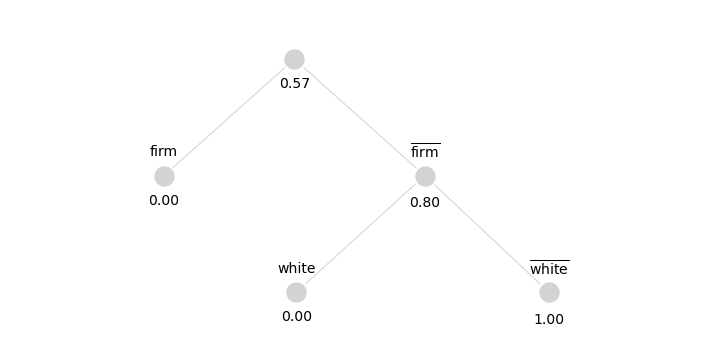

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

draw_decision_poset(
    DT1,
    dict(
        VSL_PARAMS,
        #node_color=['palegreen' if el_i in {4, 2} else 'lightcoral' if el_i in {1, 3} else 'lightgrey' for el_i in range(len(DT1))],
        #node_color=[crule.target for crule in DT1],
        cmap='RdBu',
    ),
    draw_node_indices=False,
    ax=ax,
    label_func=lambda el_i, DP: short_label_func(el_i, DP, draw_emptyset=False, draw_premise_len=False), #label_func,
    dy_coefs=(0.1, 0.1), dx_coefs=(0.25,0.25),
    #nodes_pos=nodes_poss[ax_i],
    off_axis=True,
    nodes_dx={3: 0.83+0.4, 2: -0.41}
)
#ax.set_title('Decision Tree', size=18)
plt.tight_layout()
plt.savefig('imgs/Decision_tree.eps', dpi=1200)
plt.show()

## Concepts Tree

In [30]:
def concept_label_func(vsl, c_i, max_new_intent_count=5, max_new_extent_count=5, top_labels=None):
    if top_labels is None:
        new_intent = list(vsl._lattice.get_concept_new_intent(c_i))
    else:
        new_intent = top_labels[c_i]
        
    if len(new_intent) > 0:
        new_intent = [re.sub(r'[^_]+_is_', '', m) for m in new_intent]
        new_intent = [m.replace('_', ' ') for m in new_intent]
        new_intent = ['$\overline{\mathrm{'+m[4:].replace(' ','\ ')+'}}$' if m.startswith('not ') else m for m in new_intent]
    else:
        #new_intent = ['$\emptyset$']
        pass
    
    if len(new_intent) > 0:
        new_intent_str = ', '.join(new_intent[:max_new_intent_count])
        if len(new_intent_str) > 0 \
                and max_new_intent_count is not None and len(new_intent) > max_new_intent_count:
            new_intent_str += '...'
    else:
        new_intent_str = ''

    new_extent = list(vsl._lattice.get_concept_new_extent(c_i))
    new_extent = [g.replace(' ', '\n') for g in new_extent]
    if any(['\n' in g for g in new_extent]):
        new_intent_str = '\n' + new_intent_str
    if len(new_extent) > 0:
        new_extent_str = ', '.join(new_extent[:max_new_extent_count])
        if len(new_extent_str) > 0 \
                and max_new_extent_count is not None and len(new_extent) > max_new_extent_count:
            new_extent_str += '...'
    else:
        new_extent_str = ''

    label = '\n\n\n'.join([new_intent_str, new_extent_str])
    return label

In [31]:
def label_func_concept(c_i, L, max_int_per_line=None, max_ext_per_line=None, draw_emptyset=True, top_labels=None):
    c = L[c_i]
    #intent_verb = ', '.join(premise_verb(c.intent))
    #extent_verb = ', '.join(premise_verb(c.extent))
    
    if top_labels is None:
        new_intent = L.get_concept_new_intent(c_i)
    else:
        new_intent = top_labels[c_i]
    
    intent_verb = ', '.join(premise_verb(new_intent, draw_emptyset=draw_emptyset))
    extent_verb = ', '.join(premise_verb(L.get_concept_new_extent(c_i), draw_emptyset=draw_emptyset))
    
    if max_ext_per_line is not None:
        new_ext = extent_verb.split(', ')
        new_ext_ = [ ', '.join(new_ext[i*max_ext_per_line:(i+1)*max_ext_per_line]) for i in range(len(new_ext)//max_ext_per_line+1) ]
        new_ext_ = [g for g in new_ext_ if g != '']
        new_ext = ',\n'.join(new_ext_)
        extent_verb = new_ext.strip(',')
        
    if max_int_per_line is not None:
        new_int = intent_verb.split(', ')
        new_int_ = [ ', '.join(new_int[i*max_int_per_line:(i+1)*max_int_per_line]) for i in range(len(new_int)//max_int_per_line+1) ]
        new_int_ = [m for m in new_int_ if m != '']
        new_int = ',\n'.join(new_int_)
        new_int = new_int.strip(',')
        intent_verb = new_int
        
    intent_nlines, extent_nlines = len(intent_verb.split('\n')), len(extent_verb.split('\n'))
    max_nlines = max(intent_nlines, extent_nlines)
    
    intent_verb = '\n'*(max_nlines-intent_nlines) + intent_verb
    extent_verb = extent_verb + '\n'*(max_nlines-extent_nlines)
    
    #return '\n\n\n'.join([intent_verb, extent_verb])
    return '\n\n'.join([intent_verb, extent_verb])+'\n'

In [32]:
def short_label_func_concept(c_i, L, max_new_intent_count=3, max_new_extent_count=3, draw_new_intent_len=True, draw_new_extent_len=True, draw_emptyset=True, top_labels=None):
    if top_labels is None:    
        new_intent = list(L.get_concept_new_intent(c_i))
    else:
        new_intent = top_labels[c_i]
    new_intent = premise_verb(new_intent, draw_emptyset)
    
    if len(new_intent) > 0 and not (len(new_intent)==1 and new_intent[0] == ''):
        new_intent_str = f"{len(new_intent)}: " if draw_new_intent_len else ""
        new_intent_str += ', '.join(new_intent[:max_new_intent_count])
        if len(new_intent_str) > 0 \
                and max_new_intent_count is not None and len(new_intent) > max_new_intent_count:
            new_intent_str += '...'
    else:
        new_intent_str = ''

    new_extent = premise_verb(list(L.get_concept_new_extent(c_i)), draw_emptyset)
    if len(new_extent) > 0 and not (len(new_extent)==1 and new_extent[0] == ''):
        new_extent_str = f"{len(new_extent)}: " if draw_new_extent_len else ""
        new_extent_str += ', '.join(new_extent[:max_new_extent_count])
        if len(new_extent_str) > 0 \
                and max_new_extent_count is not None and len(new_extent) > max_new_extent_count:
            new_extent_str += '...'
    else:
        new_extent_str = ''

    label = '\n\n'.join([new_intent_str, new_extent_str])
    return label

In [33]:
def draw_concept_lattice(
    L, vsl_params, draw_node_indices=False, label_func=None, ax=None,
    dx_coefs=(0,0), dy_coefs=(0,0), xlim=None, ylim=None,
    nodes_dx=None, nodes_dy=None, nodes_pos=None,
    off_axis=True, draw_bottom_concept=True,
):    
    if ax is None:
        fig, ax = plt.subplots()
        
    nodes_dx = nodes_dx if nodes_dx is not None else {}
    nodes_dy = nodes_dy if nodes_dy is not None else {}
    nodes_pos = nodes_pos if nodes_pos is not None else {}
        
    L_vsl = ConceptLatticeVisualizer(L, **vsl_params)
    for n_i, pos in nodes_pos.items():
        L_vsl._pos[n_i] = pos
    for n_i, dx in nodes_dx.items():
        L_vsl._pos[n_i][0] += dx
    for n_i, dy in nodes_dy.items():
        L_vsl._pos[n_i][1] += dy
    
    
    L_vsl.draw_networkx(
        draw_node_indices=draw_node_indices, ax=ax,
        label_func=(lambda el_i: label_func(el_i, L)) if label_func is not None else None,
        draw_bottom_concept=draw_bottom_concept,
    )
    if xlim is None:
        xmin, xmax = ax.get_xlim()
        dx = xmax-xmin
        xmin, xmax = xmin-dx*dx_coefs[0], xmax+dx*dx_coefs[1]
    else:
        xmin, xmax = xlim
    
    if ylim is None:
        ymin, ymax = ax.get_ylim()
        dy = ymax-ymin
        ymin, ymax = ymin-dy*dy_coefs[0], ymax+dy*dy_coefs[1]
    else:
        ymin, ymax = ylim
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    if off_axis:
        ax.set_axis_off()
        
    return L_vsl

In [34]:
from importlib import reload

In [35]:
dts = reload(dts)

In [36]:
L1 = dts.concept_lattice_from_decision_tree(K_X_dich, DT1)

In [37]:
ylim = (-0.5, 4.5)

In [38]:
levels = [4, 3, 2, 1, 0]

In [39]:
nodes_pos = {0: (0, levels[0]), 4: (-1, levels[2]), 1: (2, levels[1]), 3: (1, levels[3]), 2: (3, levels[3]), 5: (0, levels[4]) }

In [40]:
node_colors_L1 = [cmap(64) if i != 5 else cmap(0) for i in range(len(L1))]

In [41]:
xlim = (-2, 4)
#ylim = (-0.5, 3.5)

In [42]:
top_labels_DT1_full = [drule.premise for drule in DT1]
top_labels_DT1 = [tuple(sorted(set(label)-set( top_labels_DT1_full[list(DT1.direct_super_elements(drule_i))[0]] ), key=lambda m: (m.startswith('not_'), m)))
                  if len(DT1.super_elements(drule_i))>0 else label for drule_i, label in enumerate(top_labels_DT1_full)]

In [43]:
top_labels_L1 = []
for c_i, c in enumerate(L1):
    label = tuple(L1.get_concept_new_intent(c_i))
    if c_i < len(top_labels_DT1):
        label = list(top_labels_DT1[c_i])+list(set(label)-set(top_labels_DT1[c_i]))
        label = tuple(label)
    label = tuple(sorted(label, key=lambda m: (m.startswith('not_'), m)))
    top_labels_L1.append(label)

top_labels_L1

[(),
 ('not_firm', 'not_form_is_cubic'),
 ('color_is_white',
  'form_is_round',
  'not_color_is_blue',
  'not_color_is_green',
  'not_color_is_yellow',
  'not_form_is_oval',
  'not_smooth'),
 ('not_color_is_white',),
 ('firm',
  'smooth',
  'not_color_is_blue',
  'not_color_is_yellow',
  'not_form_is_round'),
 ('color_is_blue',
  'color_is_green',
  'color_is_yellow',
  'form_is_cubic',
  'form_is_oval')]

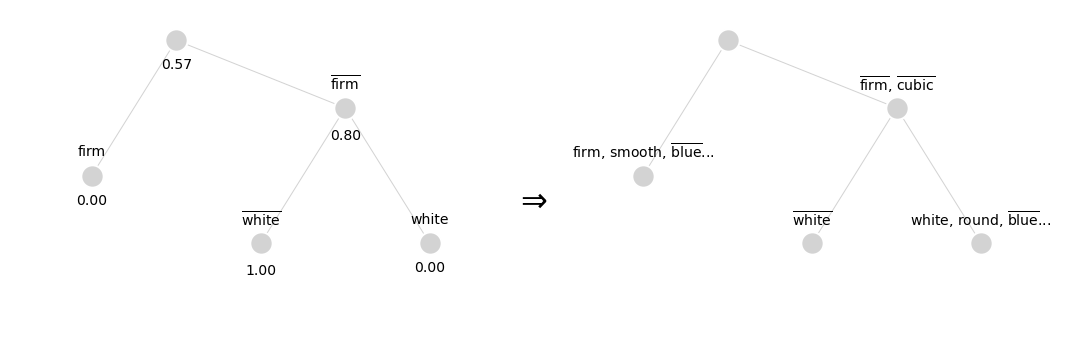

In [44]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

ax = axes[0]
dp_vsl = draw_decision_poset(
    DT1,
    dict(
        VSL_PARAMS,
        #node_color=['palegreen' if el_i in {4, 2} else 'lightcoral' if el_i in {1, 3} else 'lightgrey' for el_i in range(len(DT1))],
        #node_color=[crule.target for crule in DT1],
        node_color = 'lightgrey', #node_colors_L1[:-1],
        #cmap = cmap,
        #cmap='Blues',
        #cmap='RdBu',
        node_edgecolor='white',
        node_linewidth=2, node_size=500
    ),
    draw_node_indices=False,
    ax=ax,
    label_func=lambda el_i, DP: short_label_func(el_i, DP, draw_emptyset=False, draw_premise_len=False, top_labels=top_labels_DT1), #dy_coefs=(0.1, 0.1), dx_coefs=(0.25,0.25),
    #nodes_pos=nodes_poss[ax_i],
    off_axis=True,
    #nodes_dx={3: 0.83+0.4, 2: -0.41}
    nodes_pos=nodes_pos,
    xlim=xlim, ylim=ylim
)

ax.set_xlim(*xlim)
ax.set_ylim(*ylim)


ax = axes[1]
draw_concept_lattice(
    L1,
    dict(
        VSL_PARAMS,
        node_color='lightgrey',#node_colors_L1
    ),
    draw_node_indices=False,
    ax=ax, xlim=xlim, ylim=ylim, nodes_pos=nodes_pos,
    #label_func=lambda c_i, L: short_label_func_concept(c_i, L, 3, 3, draw_emptyset=False, draw_new_extent_len=False, draw_new_intent_len=False),
    label_func=lambda c_i, L: short_label_func_concept(
        c_i, L, 3, 3, draw_emptyset=False, draw_new_extent_len=False, draw_new_intent_len=False, top_labels=top_labels_L1
    ).split('\n\n')[0]+'\n\n\n',
    draw_bottom_concept=False
)

axes[0].text(4,1.5,'$\Rightarrow$', size=32)

plt.tight_layout()

plt.savefig('imgs/DT_to_L_step0.eps', dpi=1200)
plt.show()

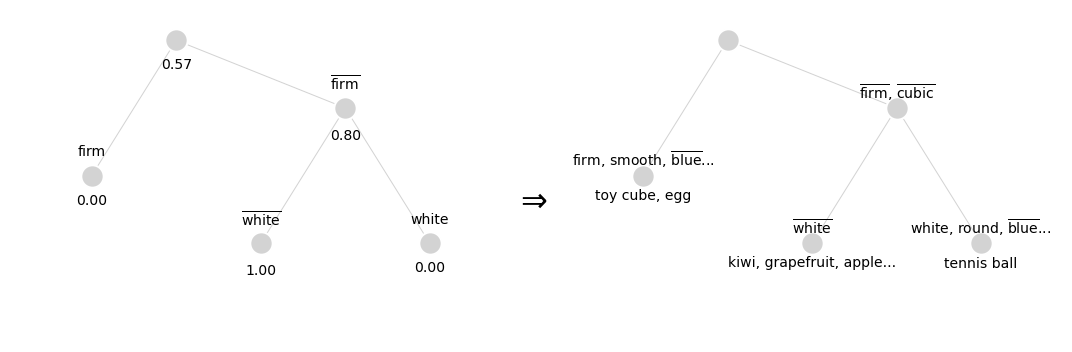

In [45]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

ax = axes[0]
dp_vsl = draw_decision_poset(
    DT1,
    dict(
        VSL_PARAMS,
        #node_color=['palegreen' if el_i in {4, 2} else 'lightcoral' if el_i in {1, 3} else 'lightgrey' for el_i in range(len(DT1))],
        #node_color=[crule.target for crule in DT1],
        node_color = 'lightgrey', #node_colors_L1[:-1],
        #cmap = cmap,
        #cmap='Blues',
        #cmap='RdBu',
        node_edgecolor='white',
        node_linewidth=2, node_size=500
    ),
    draw_node_indices=False,
    ax=ax,
    label_func=lambda el_i, DP: short_label_func(el_i, DP, draw_emptyset=False, draw_premise_len=False, top_labels=top_labels_DT1), #dy_coefs=(0.1, 0.1), dx_coefs=(0.25,0.25),
    #nodes_pos=nodes_poss[ax_i],
    off_axis=True,
    #nodes_dx={3: 0.83+0.4, 2: -0.41}
    nodes_pos=nodes_pos,
    xlim=xlim, ylim=ylim
)

ax.set_xlim(*xlim)
ax.set_ylim(*ylim)


ax = axes[1]
draw_concept_lattice(
    L1,
    dict(
        VSL_PARAMS,
        node_color='lightgrey',#node_colors_L1
    ),
    ax=ax, xlim=xlim, ylim=ylim, nodes_pos=nodes_pos,
    #label_func=lambda c_i, L: short_label_func_concept(c_i, L, 3, 3, draw_emptyset=False, draw_new_extent_len=False, draw_new_intent_len=False),
    label_func=lambda c_i, L: short_label_func_concept(c_i, L, 3, 3, draw_emptyset=False, draw_new_extent_len=False, draw_new_intent_len=False, top_labels=top_labels_L1),
    draw_bottom_concept=False
)

axes[0].text(4,1.5,'$\Rightarrow$', size=32)

plt.tight_layout()

plt.savefig('imgs/DT_to_L_step1.eps', dpi=1200)
plt.show()

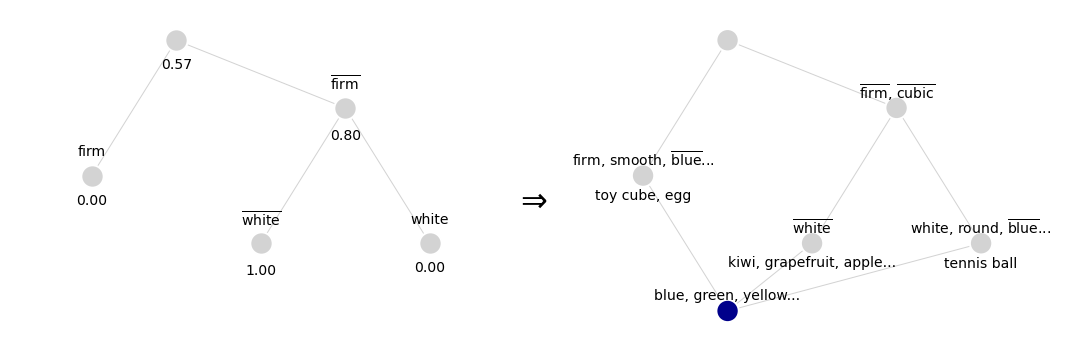

In [46]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

ax = axes[0]
dp_vsl = draw_decision_poset(
    DT1,
    dict(
        VSL_PARAMS,
        #node_color=['palegreen' if el_i in {4, 2} else 'lightcoral' if el_i in {1, 3} else 'lightgrey' for el_i in range(len(DT1))],
        #node_color=[crule.target for crule in DT1],
        node_color = 'lightgrey', #node_colors_L1[:-1],
        #cmap = cmap,
        #cmap='Blues',
        #cmap='RdBu',
        node_edgecolor='white',
        node_linewidth=2, node_size=500
    ),
    draw_node_indices=False,
    ax=ax,
    label_func=lambda el_i, DP: short_label_func(el_i, DP, draw_emptyset=False, draw_premise_len=False, top_labels=top_labels_DT1), #dy_coefs=(0.1, 0.1), dx_coefs=(0.25,0.25),
    #nodes_pos=nodes_poss[ax_i],
    off_axis=True,
    #nodes_dx={3: 0.83+0.4, 2: -0.41}
    nodes_pos=nodes_pos,
    xlim=xlim, ylim=ylim
)

ax.set_xlim(*xlim)
ax.set_ylim(*ylim)


ax = axes[1]
draw_concept_lattice(
    L1,
    dict(
        VSL_PARAMS,
        node_color=['lightgrey' if c_i!=L1.bottom_concept_i else cmap(255) for c_i in range(len(L1))],#'lightgrey',#node_colors_L1
    ),
    ax=ax, xlim=xlim, ylim=ylim, nodes_pos=nodes_pos,
    #label_func=lambda c_i, L: short_label_func_concept(c_i, L, 3, 3, draw_emptyset=False, draw_new_extent_len=False, draw_new_intent_len=False),
    label_func=lambda c_i, L: short_label_func_concept(c_i, L, 3, 3, draw_emptyset=False, draw_new_extent_len=False, draw_new_intent_len=False, top_labels=top_labels_L1),
    draw_bottom_concept=True
)

axes[0].text(4,1.5,'$\Rightarrow$', size=32)

plt.tight_layout()

plt.savefig('imgs/DT_to_L_step2.eps', dpi=1200)
plt.show()

## Union of lattices of concepts

In [47]:
premises1 = [tuple([]), ('not_firm',), ('not_firm', 'color_is_white'), ('not_firm', 'not_color_is_white'), ('firm',) ]
#premises2 = [tuple([]), ('color_is_white',), ('not_color_is_white',)]
premises2 = [tuple([]), ('color_is_green',), ('not_color_is_green',)]

DT1 = dts.DecisionTree(premises=premises1, targets=[y[K_X_dich.extension(p)].mean() for p in premises1], leq_premise_func=dts.compare_set_function)
DT2 = dts.DecisionTree(premises=premises2, targets=[y[K_X_dich.extension(p)].mean() for p in premises2], leq_premise_func=dts.compare_set_function)

In [48]:
L1 = dts.concept_lattice_from_decision_tree(K_X_dich, DT1)
L2 = dts.concept_lattice_from_decision_tree(K_X_dich, DT2)

In [49]:
L_union = L1|L2
L_union = ConceptLattice(L_union.elements, subconcepts_dict=L_union.direct_sub_elements_dict)

In [748]:
c_i_union_1_map = {c_i: L1.index(c) for c_i, c in enumerate(L_union) if c in L1}
c_i_union_2_map = {c_i: L2.index(c) for c_i, c in enumerate(L_union) if c in L2}

In [749]:
c_i_1_union_map = {v:k for k,v in c_i_union_1_map.items()}
c_i_2_union_map = {v:k for k,v in c_i_union_2_map.items()}

In [750]:
[c_i_1_union_map[c_i_1] for c_i_1 in range(len(L1))]

[0, 1, 2, 3, 4, 5]

In [751]:
from copy import deepcopy

In [752]:
nodes_pos_L1 = deepcopy(nodes_pos)

In [753]:
#nodes_pos_L2 = {0: (0,3), 1: (1, 2), 2:(-1, 2), 3: (0, 0)}
nodes_pos_L2 = {0: (0,levels[0]), 1: (1, levels[2]), 2:(-1, levels[1]), 3: (0, levels[4])}

In [754]:
#xcoords = [-2.25, -0.85, 0, 0.85, 2.25]
xcoords = [-2, -0.75, 0, 0.75, 2]
nodes_pos_unite = {
    0: (xcoords[2], levels[0]),
    1: (xcoords[1], levels[1]),
    7: (xcoords[3], levels[1]),
    4: (xcoords[0], levels[2]),
    6: (xcoords[4], levels[2]),
    3: (xcoords[1], levels[3]),
    2: (xcoords[3], levels[3]),
    5: (xcoords[2], levels[4]),
}
nodes_pos_unite

{0: (0, 4),
 1: (-0.75, 3),
 7: (0.75, 3),
 4: (-2, 2),
 6: (2, 2),
 3: (-0.75, 1),
 2: (0.75, 1),
 5: (0, 0)}

In [755]:
from matplotlib import gridspec

In [756]:
node_colors = [
    [cmap(64) if i != 5 else cmap(0) for i in range(len(L1))],
    [cmap(255) if i != 3 else cmap(0) for i in range(len(L2))],
    #[cmap(255) for i in range(len(L_union))],
    [cmap(0) if i == 5 else
     cmap(164) if i in c_i_union_1_map and i in c_i_union_2_map else
     cmap(64) if i in c_i_union_1_map else
     cmap(255)
     for i in range(len(L_union))],
]

In [757]:
xlims = [(-2.3, 4.2), (-2, 2), (-2.6, 2.9)]

In [758]:
nodes_poses = [nodes_pos_L1, nodes_pos_L2, nodes_pos_unite]

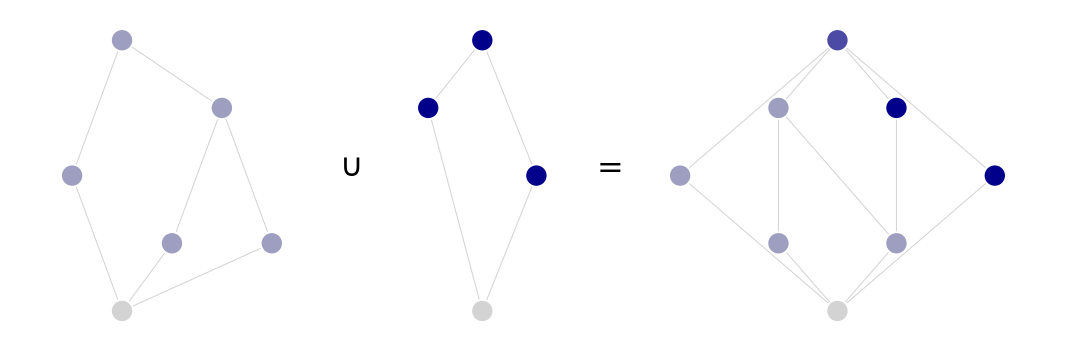

In [759]:
fig = plt.figure(figsize=(15,5))

gs = gridspec.GridSpec(1, 3, width_ratios=[1.5, 1, 2]) 
axes = [plt.subplot(gs[i]) for i in range(3)]

xlim = (-2, 4)
#ylim = (-0.5, 3.5)

Ls = [L1, L2, L_union]

for ax_i, ax in enumerate(axes):
    L = Ls[ax_i]
    
    draw_concept_lattice(
        L, 
        dict(
            VSL_PARAMS,
            node_color=node_colors[ax_i],
        ),
        ax=ax, nodes_pos = nodes_poses[ax_i] if ax_i in {0, 1, 2} else None, # xlim=xlim, ylim=ylim, nodes_pos=nodes_pos,
        #label_func=lambda c_i, L: short_label_func_concept(c_i, L, 2, 1, draw_emptyset=False, draw_new_extent_len=False, draw_new_intent_len=False),
        label_func=lambda c_i, L: '',
        draw_node_indices=False,
        xlim=xlims[ax_i], ylim=ylim,
        off_axis=True,
    )

axes[0].text(4.35, 2,'$\cup$', size=32)
axes[1].text(2,2,'$=$', size=32)

plt.tight_layout()

plt.savefig('imgs/L_union.eps', dpi=1200)
plt.show()

# Prediction by lattice of concepts

## Prediction by decision tree

In [760]:
def node_colors_traced(DP, x, highlight_bottom=True):
    bottom_el, traced_el = DP.premises.trace_element(x, 'down')
    node_colors = [cmap(255) if el_i in bottom_el and highlight_bottom else cmap(127) if el_i in traced_el else cmap(0) for el_i in range(len(DP))]
    return node_colors

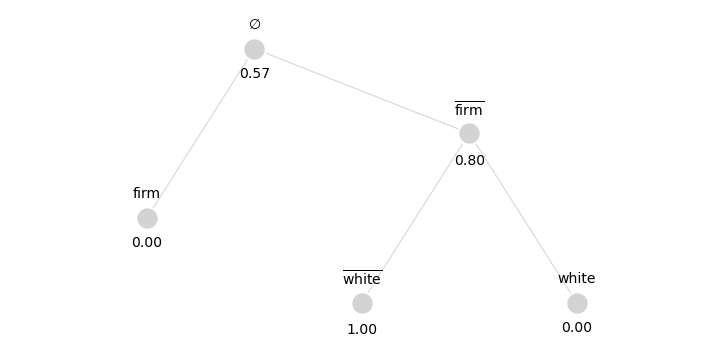

In [761]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)


draw_decision_poset(
    DT1, 
    dict(
        VSL_PARAMS,
        node_color='lightgrey',
    ),
    nodes_pos=nodes_pos_L1,
    label_func=lambda el_i, DT1: short_label_func(el_i, DT1, draw_emptyset=True, draw_premise_len=False, top_labels=top_labels_DT1), #label_func(el_i, DT1, draw_emptyset=True, draw_premise_len=False),
    #xlim=xlims[0], ylim=ylim,
    xlim=xlims[0], ylim=(ylim[0]+1, ylim[1]),
    off_axis=True,
    draw_node_indices=False,
    ax=ax
)
plt.tight_layout()

plt.savefig('imgs/DT_preds_step0.eps', dpi=1200)
plt.show()

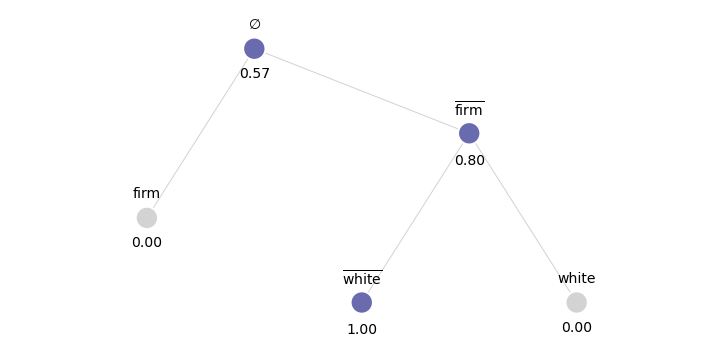

In [762]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)


draw_decision_poset(
    DT1, 
    dict(
        VSL_PARAMS,
        node_color=node_colors_traced(DT1, x, highlight_bottom=False)
    ),
    nodes_pos=nodes_pos_L1,
    label_func=lambda el_i, DT1: short_label_func(el_i, DT1, draw_emptyset=True, draw_premise_len=False, top_labels=top_labels_DT1), #label_func(el_i, DT1, draw_emptyset=True, draw_premise_len=False),
    #xlim=xlims[0], ylim=ylim,
    xlim=xlims[0], ylim=(ylim[0]+1, ylim[1]),
    off_axis=True,
    draw_node_indices=False,
    ax=ax
)
plt.tight_layout()

plt.savefig('imgs/DT_preds_step1.eps', dpi=1200)
plt.show()

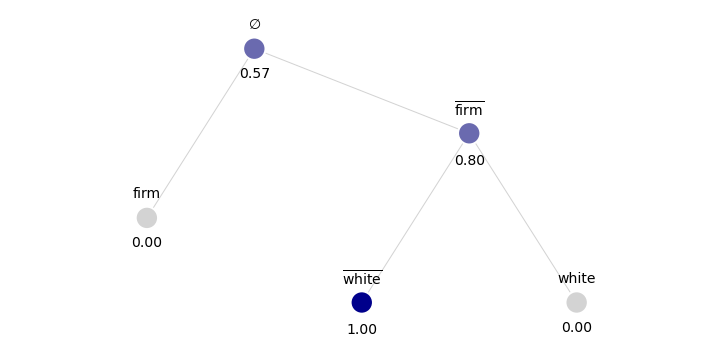

In [763]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)


draw_decision_poset(
    DT1, 
    dict(
        VSL_PARAMS,
        node_color=node_colors_traced(DT1, x)
    ),
    nodes_pos=nodes_pos_L1,
    label_func=lambda el_i, DT1: short_label_func(el_i, DT1, draw_emptyset=True, draw_premise_len=False, top_labels=top_labels_DT1), #label_func(el_i, DT1, draw_emptyset=True, draw_premise_len=False),
    #xlim=xlims[0], ylim=ylim,
    xlim=xlims[0], ylim=(ylim[0]+1, ylim[1]),
    off_axis=True,
    draw_node_indices=False,
    ax=ax
)
plt.tight_layout()

plt.savefig('imgs/DT_preds_step2.eps', dpi=1200)
plt.show()

## Decision Lattice

In [764]:
from fcapy.ml.decision_lattice import DecisionLatticeRegressor

In [765]:
DL = DecisionLatticeRegressor()
DL._lattice = deepcopy(L_union)
for c_i, c in enumerate(DL._lattice):
    metrics = DL.calc_concept_prediction_metrics(c_i, y)
    c.measures = dict(metrics, **c.measures)

In [766]:
DL._lattice.bottom_concept.measures

{'mean_y': None}

In [767]:
dts = reload(dts)

In [768]:
bottom_i = DL._lattice.bottom_concept_i
drop_bottom_concept = DL._lattice.bottom_concept.measures['mean_y'] is None

DL_poset = dts.DecisionPOSet(
    premises=[c.intent for c_i, c in enumerate(DL._lattice)],
    targets=[c.measures['mean_y'] for c_i, c in enumerate(DL._lattice)],
    direct_subelements_dict=deepcopy(DL._lattice.subconcepts_dict),
    leq_premise_func=dts.compare_set_function,
)

if drop_bottom_concept:
    del DL_poset[bottom_i]

In [769]:
intents = [c.intent for c in L_union]

In [770]:
c_i_poset_DL_map = {p_i: intents.index(p) for p_i, p in enumerate(DL_poset.premises)}
c_i_DL_poset_map = {v:k for k,v in c_i_poset_DL_map.items()}

In [771]:
top_labels_Lunion = [sorted(L_union.get_concept_new_intent(c_i), key=lambda int_: (int_.startswith('not_'), int_)) for c_i, c in enumerate(L_union)]

In [772]:
top_labels_DT1_full = [drule.premise for drule in DT1]
top_labels_DT1 = [sorted(set(label)-set( top_labels_DT1_full[list(DT1.direct_super_elements(drule_i))[0]] ))
                  if len(DT1.super_elements(drule_i))>0 else label for drule_i, label in enumerate(top_labels_DT1_full)]

In [773]:
top_labels_DL_poset_all = [drule.premise for drule in DL_poset]
top_labels_DL_poset = []
for drule_i, drule in enumerate(DL_poset):
    p = set(top_labels_DL_poset_all[drule_i])
    for dsup_i in DL_poset.direct_super_elements(drule_i):
        p -= set(top_labels_DL_poset_all[dsup_i])
    p = tuple(sorted(p, key=lambda m: (m.startswith('not_'), m)))
    top_labels_DL_poset.append(p)

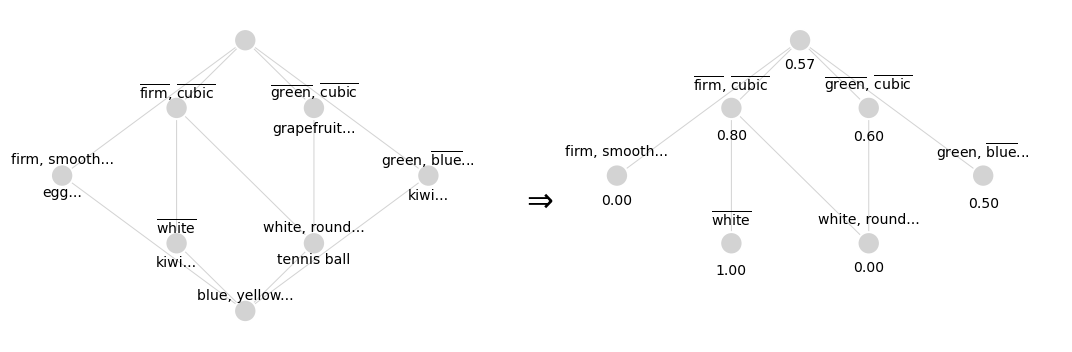

In [774]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

ax = axes[0]
L_vsl = draw_concept_lattice(
    L_union,
    dict(
        VSL_PARAMS,
        #node_color=[cmap(64) if c_i != L_union.bottom_concept_i else cmap(0) for c_i in range(len(L_union))]
        #node_color=[cmap(0) if c_i != L_union.bottom_concept_i else cmap(255) for c_i in range(len(L_union))]
        node_color=[cmap(0) for c_i in range(len(L_union))]
    ),
    ax=ax,
    nodes_pos=nodes_pos_unite,
    xlim=xlims[-1], ylim=ylim,
    label_func=lambda c_i, L_union: short_label_func_concept(
        c_i, L_union, 2, 1, draw_emptyset=False, draw_new_extent_len=False, draw_new_intent_len=False,top_labels=top_labels_Lunion),
    off_axis=True,
    draw_node_indices=False
)


ax = axes[1]
draw_decision_poset(
    DL_poset, 
    dict(
        VSL_PARAMS,
        #node_color=[cmap(64) for crule_i in range(len(DL_poset))],
        node_color=[cmap(0) for crule_i in range(len(DL_poset))],
    ),
    nodes_pos={c_i_DL_poset_map[k]:v for k,v in nodes_pos_unite.items() if k in c_i_DL_poset_map},
    ax=ax,
    label_func=lambda c_i, DL_poset: short_label_func(
        c_i, DL_poset, max_premise_count=2, draw_emptyset=False, draw_premise_len=False, top_labels=top_labels_DL_poset),
    xlim=xlims[-1], ylim=ylim,
    off_axis=True,
    draw_node_indices=False
)

axes[0].text(3,1.5,'$\Rightarrow$', size=32)

plt.tight_layout()

plt.savefig('imgs/L_to_DL.eps', dpi=1200)
plt.show()

## Prediction by decision lattice

In [775]:
bottom_els_i, traced_els_i = DL_poset.premises.trace_element(x, 'down')
bottom_els_i = list(bottom_els_i)
bottom_els_i

[3, 5]

In [776]:
bottom_els = DL_poset[bottom_els_i]

In [777]:
premise_comb = set()
for el in bottom_els:
    premise_comb |= set(el.premise)
premise_comb = tuple(sorted(premise_comb))

target_comb = np.mean([el.target for el in bottom_els])

crule_comb = dts.ClassificationRule(premise_comb, target_comb)

In [778]:
dts = reload(dts)

In [779]:
DL_aug = deepcopy(DL_poset)

In [780]:
DL_aug.add(crule_comb)

In [781]:
[nodes_pos_unite[el_i][0] for el_i in bottom_els_i]

[-0.75, 0]

In [782]:
nodes_pos_aug = {c_i_DL_poset_map[k]:v for k,v in nodes_pos_unite.items() if k in c_i_DL_poset_map}

#crule_comb_pos_x = np.mean([nodes_pos_aug[el_i][0] for el_i in bottom_els_i])
crule_comb_pos_x = xcoords[3]

nodes_pos_aug[len(DL_aug)-1] = (crule_comb_pos_x, levels[4])

In [783]:
bottom_els_i

[3, 5]

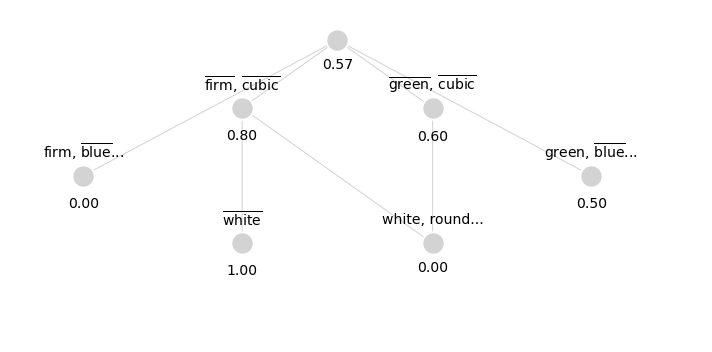

In [784]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)

draw_decision_poset(
    DL_poset, 
    dict(
        VSL_PARAMS,
        node_color='lightgrey', #node_colors_traced(DL_poset, x, highlight_bottom=False),
    ),
    nodes_pos=nodes_pos_aug,
    ax=ax,
    label_func=lambda c_i, DP: short_label_func(c_i, DP, max_premise_count=2, draw_emptyset=False, draw_premise_len=False),
    xlim=xlims[-1], ylim=ylim,
    off_axis=True,
    draw_node_indices=False
)
plt.tight_layout()

plt.savefig('imgs/DL_preds_step0.eps', dpi=1200)
plt.show()

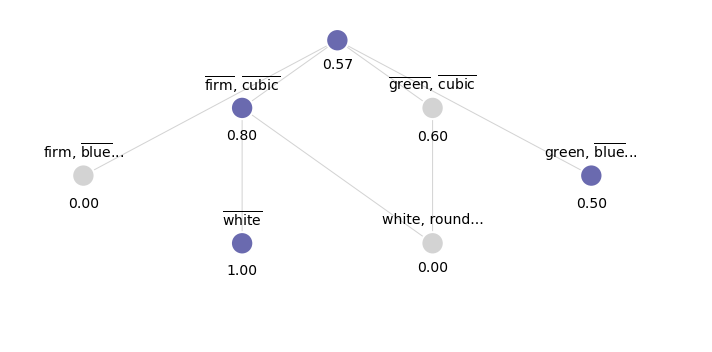

In [785]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)

draw_decision_poset(
    DL_poset, 
    dict(
        VSL_PARAMS,
        node_color=node_colors_traced(DL_poset, x, highlight_bottom=False),
    ),
    nodes_pos=nodes_pos_aug,
    ax=ax,
    label_func=lambda c_i, DP: short_label_func(c_i, DP, max_premise_count=2, draw_emptyset=False, draw_premise_len=False),
    xlim=xlims[-1], ylim=ylim,
    off_axis=True,
    draw_node_indices=False
)
plt.tight_layout()

plt.savefig('imgs/DL_preds_step1.eps', dpi=1200)
plt.show()

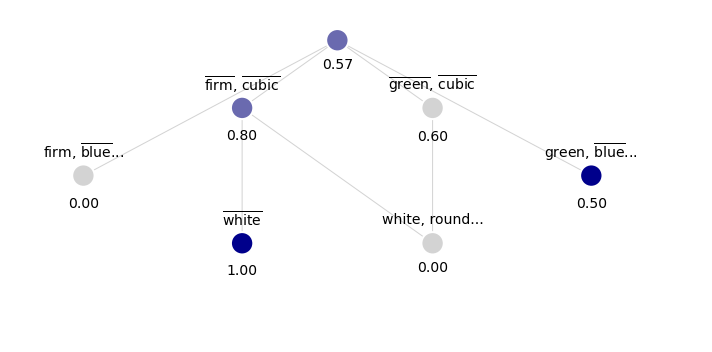

In [786]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)

draw_decision_poset(
    DL_poset, 
    dict(
        VSL_PARAMS,
        #node_color=node_colors_traced(DL_poset, x)+['orange']
        node_color=node_colors_traced(DL_poset, x)#+['white'],
        #node_edgecolor=['white']*len(DL_poset)+[cmap(255)]
    ),
    nodes_pos=nodes_pos_aug,
    ax=ax,
    label_func=lambda c_i, DP: short_label_func(c_i, DP, max_premise_count=2, draw_emptyset=False, draw_premise_len=False),
    xlim=xlims[-1], ylim=ylim,
    off_axis=True,
    draw_node_indices=False
)
plt.tight_layout()

plt.savefig('imgs/DL_preds_step2.eps', dpi=1200)
plt.show()

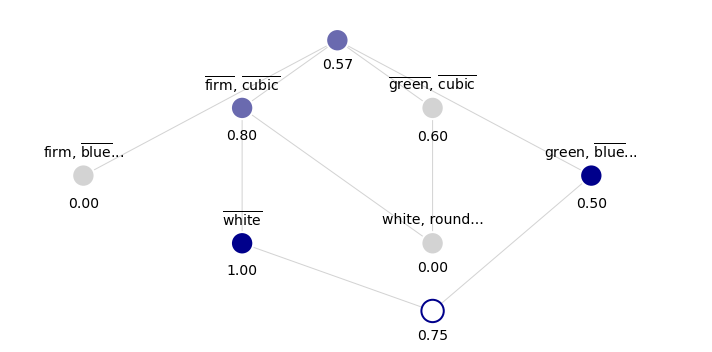

In [787]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)

draw_decision_poset(
    DL_aug, 
    dict(
        VSL_PARAMS,
        #node_color=node_colors_traced(DL_poset, x)+['orange']
        node_color=node_colors_traced(DL_poset, x)+['white'],
        node_edgecolor=['white']*len(DL_poset)+[cmap(255)]
    ),
    nodes_pos=nodes_pos_aug,
    ax=ax,
    label_func=lambda c_i, DP: short_label_func(c_i, DP, max_premise_count=2, draw_emptyset=False, draw_premise_len=False),
    xlim=xlims[-1], ylim=ylim,
    off_axis=True,
    draw_node_indices=False
)
plt.tight_layout()

plt.savefig('imgs/DL_preds_step3.eps', dpi=1200)
plt.show()

# Experiments

## Time to construct a concept lattice

## Classification quality

In [788]:
def prepare_result_table_tolatex(res_ds, models_order, ds_type, metric, ascending=False):
    train_pivot_ds = res_ds.pivot_table(index='model',columns='ds', values=f'{metric}_{ds_type}')
    train_pivot_ds = train_pivot_ds.loc[models_order]
    train_pivot_ds = train_pivot_ds.T

    train_pivot_ds = train_pivot_ds.round(2)
    train_pivot_ds_rank = train_pivot_ds.rank(1, ascending=not ascending)
    train_pivot_ds.loc['mean rank'] = train_pivot_ds_rank.mean(0)
    train_pivot_ds = train_pivot_ds.round(2)
    
    return train_pivot_ds

In [789]:
def combine_train_test_tables(res_ds, models_order, metric, ascending=False):
    cdss = []
    for ds_type in ['train', 'test']:
        cds = prepare_result_table_tolatex(res_ds, models_order, ds_type, metric, ascending=ascending).T
        columns_order = cds.columns
        cds.columns = pd.MultiIndex.from_tuples([(f, ds_type) for f in cds.columns])
        cdss.append(cds)
    cds = pd.concat(cdss, 1)
    cds = cds[[(f, ds_type) for f in columns_order for ds_type in ['train', 'test']]]
    return cds

In [790]:
def prepare_result_table_tolatex_diff(res_ds, models_order, ds_type, metric, ascending=False):
    train_pivot_ds = res_ds.pivot_table(index='model',columns='ds', values=f'{metric}_{ds_type}')
    train_pivot_ds = train_pivot_ds.loc[models_order]
    train_pivot_ds = train_pivot_ds
    train_pivot_ds.loc['best'] = train_pivot_ds.max() if ascending else train_pivot_ds.min()
    train_pivot_ds.iloc[:-1] = (train_pivot_ds.iloc[:-1]-train_pivot_ds.loc['best'])
    train_pivot_ds['mean diff'] = train_pivot_ds.mean(1)
    
    #train_pivot_ds['mean diff rank'] = train_pivot_ds.drop('best')['mean diff'].rank(ascending=ascending)
    train_pivot_ds = train_pivot_ds.round(2)
    
    train_pivot_ds = train_pivot_ds.T
    
    return train_pivot_ds

In [791]:
def combine_train_test_tables_diff(res_ds, models_order, metric, ascending=False):
    cdss = []
    for ds_type in ['train', 'test']:
        cds = prepare_result_table_tolatex_diff(res_ds, models_order, ds_type, metric, ascending=ascending).T
        columns_order = cds.columns
        cds.columns = pd.MultiIndex.from_tuples([(f, ds_type) for f in cds.columns])
        cdss.append(cds)
    #return cdss
    cds = pd.concat(cdss, 1)
    cds = cds[[(f, ds_type) for f in columns_order for ds_type in ['train', 'test']]]
    return cds

In [792]:
res_ds = pd.read_csv('evaluation_classif_full.csv', index_col=0)
print(res_ds.shape)
res_ds.head()

(480, 18)


,model,ds,fold_id,train_size,test_size,time,param_random_state,metric_accuracy_train,metric_accuracy_test,metric_f1_train,metric_f1_test,metric_roc_train,metric_roc_test,param_n_estimators,param_max_depth,param_algo,param_algo_params,param_gen_algo
0,DecisionTreeClassifier,adult,0,26048,6513,0.105370,42,0.999578,0.787502,0.999122,0.564780,0.999123,0.713776,NaN,NaN,NaN,NaN,NaN
1,RandomForestClassifier,adult,0,26048,6513,0.087283,42,0.850392,0.829418,0.634462,0.579326,0.744208,0.712558,5.0,10.0,NaN,NaN,NaN
2,RandomForestClassifier,adult,0,26048,6513,2.493777,42,0.999539,0.826961,0.999043,0.609629,0.999370,0.735879,NaN,NaN,NaN,NaN,NaN
3,GradientBoostingClassifier,adult,0,26048,6513,2.102144,42,0.849048,0.838323,0.645957,0.622174,0.754491,0.740548,NaN,NaN,NaN,NaN,NaN
4,LGBMClassifier,adult,0,26048,6513,308.169476,42,0.865748,0.841701,0.694665,0.641641,0.786789,0.754919,NaN,NaN,NaN,NaN,NaN


In [793]:
import json

In [794]:
res_ds['model_base'] = [x.replace('Regressor','').replace('Classifier', '') for x in res_ds['model']]
flg = res_ds['param_n_estimators'].isna()
res_ds.loc[flg, 'param_n_estimators'] = [
    json.loads(x.replace("'", '"'))['rf_params']['n_estimators']
    if x is not None and type(x)==str and 'rf_params' in x else None for x in res_ds.loc[flg, 'param_algo_params']]

res_ds['model'] = res_ds['model_base']+'_'+res_ds['param_algo'].fillna('')+'_'+res_ds['param_n_estimators'].fillna('').astype(str)
res_ds['model'] = res_ds['model']+'_'+res_ds['param_gen_algo'].replace('approximate','approx.').fillna('')

for s_from, s_to in [
    ('DecisionTree', 'DT'), ('GradientBoosting', 'GB'), ('CatBoost', "CB"),
    ('DecisionLattice', 'DL'), ('RandomForest', 'RF'), ('.0','',),
    ('__','_')
]:
    res_ds['model'] = [x.replace(s_from, s_to).strip('_') for x in res_ds['model']]

rf_vs_fca_models = ['DL_RF_5','DL_RF_5_approx.','DL_RF_5_exact','RF_5']

In [795]:
models_order = [
    'DL_RF_5',# 'DL_RF_5_approx.', 'DL_RF_5_exact',
    'DL_RF_10',# 'DL_RF_10_approx.',
    'DL_Sofia', #'DL_Sofia_approx.', 'DL_Sofia_exact', 
    'DT','RF_5', 'RF', 'GB', 'LGBM',  'CB',
]

In [796]:
metric = 'metric_f1'
cds = combine_train_test_tables_diff(res_ds, models_order, metric, ascending=True)

cds = cds[[( 'mean diff', 'train'), ( 'mean diff',  'test')]]
cds.columns = [f[1] for f in cds.columns]

In [797]:
cds_best0 = cds.copy()
cds_best0.loc['best'] = 0

In [798]:
import seaborn as sns

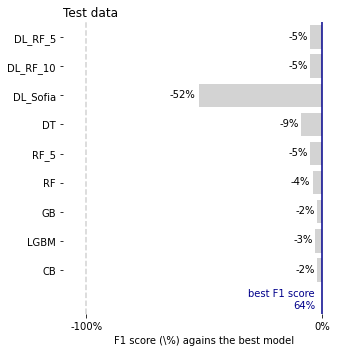

In [799]:
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(5, 5)

ds_part = 'test'
ax = axes

sns.barplot(x=cds_best0[ds_part], y=cds_best0.index, color=cmap(0), ax=ax)

ax.set_xlim(-1.1, 0.1)
#xticks = np.arange(-1, 0.01, 0.2)
#xticks = []
xticks = [-1, 0]
ax.set_xticks(xticks)
ax.set_xticklabels([f"{x:.0%}" for x in xticks])
ax.set_title(f"{ds_part.capitalize()} data", loc='left')
ax.set_ylabel('')
ax.set_xlabel('F1 score (\%) agains the best model')

yticks = list(cds_best0.index[:-1])+['']
ax.set_yticks(range(len(yticks)-1))
ax.set_yticklabels(yticks)

for i, val in enumerate(cds_best0[ds_part].values[:-1]):
    #ax.text(val if val<-0.05 else val-0.05, i+0.05, f"{val:.0%}")
    ax.text(val-0.01*len(str(int(abs(val)*100))) , i+0.06, f"{val:.0%}", horizontalalignment='right')
#ax.text(0.01, len(cds_best0)-1+0.05, f"best F1 score\n{cds.loc['best', ds_part]:.0%}", color=cmap(255))
ax.text(-0.03, len(cds_best0)-1+0.3, f"best F1 score\n{cds.loc['best', ds_part]:.0%}", color=cmap(255), horizontalalignment='right')
ax.axvline(0, color=cmap(255))
ax.set_frame_on(False)
ax.axvline(-1, color=cmap(0), linestyle='--')
    
plt.tight_layout()
    
plt.savefig('imgs/clf_quality_test.eps', dpi=1200)
    
plt.show()

## Regression quality

In [800]:
res_ds = pd.read_csv('evaluation_regr_full1.csv', index_col=0)
print(res_ds.shape)
res_ds.head()

(200, 20)


,model,ds,fold_id,train_size,test_size,time,param_random_state,metric_mse_train,metric_mse_test,metric_mae_train,metric_mae_test,metric_r2_train,metric_r2_test,param_n_estimators,param_max_depth,param_algo,param_algo_params,param_gen_algo,metric_wape_train,metric_wape_test
0,DecisionTreeRegressor,calhouse,0,16512,4128,0.151587,42,1.051528e-31,0.793655,4.867984e-17,0.623827,1.000000,0.261216,NaN,NaN,NaN,NaN,NaN,2.248564e-17,0.370648
1,RandomForestRegressor,calhouse,0,16512,4128,0.277177,42,2.019904e-01,0.599036,3.110937e-01,0.580684,0.850314,0.442380,5.0,10.0,NaN,NaN,NaN,1.436969e-01,0.345015
2,RandomForestRegressor,calhouse,0,16512,4128,9.033681,42,3.465075e-02,0.521694,1.203863e-01,0.543827,0.974322,0.514374,NaN,NaN,NaN,NaN,NaN,5.560749e-02,0.323116
3,GradientBoostingRegressor,calhouse,0,16512,4128,2.807599,42,2.649648e-01,0.427120,3.613307e-01,0.523329,0.803647,0.602410,NaN,NaN,NaN,NaN,NaN,1.669018e-01,0.310937
4,LGBMRegressor,calhouse,0,16512,4128,200.734206,42,1.627876e-01,0.370611,2.791399e-01,0.446897,0.879366,0.655012,NaN,NaN,NaN,NaN,NaN,1.289371e-01,0.265525


In [801]:
import json

In [802]:
res_ds['model_base'] = [x.replace('Regressor','').replace('Classifier', '') for x in res_ds['model']]
flg = res_ds['param_n_estimators'].isna()
res_ds.loc[flg, 'param_n_estimators'] = [
    json.loads(x.replace("'", '"'))['rf_params']['n_estimators']
    if x is not None and type(x)==str and 'rf_params' in x else None for x in res_ds.loc[flg, 'param_algo_params']]

res_ds['model'] = res_ds['model_base']+'_'+res_ds['param_algo'].fillna('')+'_'+res_ds['param_n_estimators'].fillna('').astype(str)
res_ds['model'] = res_ds['model']+'_'+res_ds['param_gen_algo'].replace('approximate','approx.').fillna('')

for s_from, s_to in [
    ('DecisionTree', 'DT'), ('GradientBoosting', 'GB'), ('CatBoost', "CB"),
    ('DecisionLattice', 'DL'), ('RandomForest', 'RF'), ('.0','',),
    ('__','_')
]:
    res_ds['model'] = [x.replace(s_from, s_to).strip('_') for x in res_ds['model']]

rf_vs_fca_models = ['DL_RF_5','DL_RF_5_approx.','DL_RF_5_exact','RF_5']

In [803]:
models_order = [
    'DL_RF_5',# 'DL_RF_5_approx.', 'DL_RF_5_exact',
    'DL_RF_10',# 'DL_RF_10_approx.',
    'DL_Sofia', #'DL_Sofia_approx.', 'DL_Sofia_exact', 
    'DT','RF_5', 'RF', 'GB', 'LGBM',  'CB',
]

In [804]:
res_ds[res_ds['model'].isin(models_order)].groupby('model')['metric_wape_train'].mean()

model
CB          6.897526e-02
DL_RF_10    5.105807e-02
DL_RF_5     6.898987e-02
DL_Sofia    3.474529e-01
DT          6.146964e-18
GB          1.250441e-01
LGBM        9.225063e-02
RF          6.934627e-02
RF_5        1.155440e-01
Name: metric_wape_train, dtype: float64

In [805]:
metric = 'metric_wape'
cds = combine_train_test_tables_diff(res_ds, models_order, metric, ascending=False)

cds = cds[[( 'mean diff', 'train'), ( 'mean diff',  'test')]]
cds.columns = [f[1] for f in cds.columns]

In [806]:
cds_best0 = cds.copy()
cds_best0.loc['best'] = 0

In [807]:
import seaborn as sns

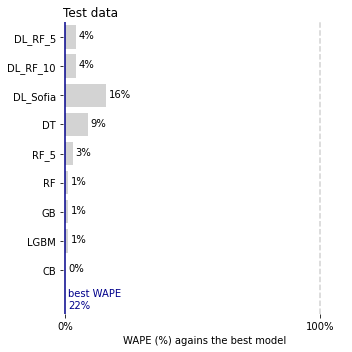

In [808]:
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(5, 5)

ds_part = 'test'
ax = axes


sns.barplot(x=cds_best0[ds_part], y=cds_best0.index, color=cmap(0), ax=ax)

ax.set_xlim(0-0.01, 1+0.1)
#xticks = np.arange(-1, 0.01, 0.2)
#xticks = []
xticks = [0, 1]
ax.set_xticks(xticks)
ax.set_xticklabels([f"{x:.0%}" for x in xticks])
ax.set_title(f"{ds_part.capitalize()} data", loc='left')
ax.set_ylabel('')
ax.set_xlabel(r'WAPE (%) agains the best model')

yticks = list(cds_best0.index[:-1])+['']
ax.set_yticks(range(len(yticks)-1))
ax.set_yticklabels(yticks)

for i, val in enumerate(cds_best0[ds_part].values[:-1]):
    #ax.text(val if val<-0.05 else val-0.05, i+0.05, f"{val:.0%}")
    ax.text(val+0.01, i+0.05, f"{val:.0%}")
#ax.text(0.01, len(cds_best0)-1+0.05, f"best WAPE\n{cds.loc['best', ds_part]:.0%}", color=cmap(255))
ax.text(0.01, len(cds_best0)-1+0.3, f"best WAPE\n{cds.loc['best', ds_part]:.0%}", color=cmap(255))
ax.axvline(0, color=cmap(255))
ax.axvline(1, color=cmap(0), linestyle='--')
ax.set_frame_on(False)


plt.tight_layout()

plt.savefig('imgs/reg_quality_test.eps', dpi=1200)
plt.show()